<a id="title_ID"></a>
# JWST Pipeline Validation Testing Notebook: MIRI LRS Slit

## Spec2: Assign_wcs()
<span style="color:red"> **Instruments Affected**</span>: FGS, MIRI, NIRCam, NIRISS, NIRSpec 

### Table of Contents
<div style="text-align: left"> 

<br> [Imports](#imports_ID) <br> [Introduction](#intro_ID) <br> [Get Documentaion String for Markdown Blocks](#markdown_from_docs) <br> [Loading Data](#data_ID) <br> [Run JWST Pipeline](#pipeline_ID) <br> [Create Figure or Print Output](#residual_ID) <br> [About This Notebook](#about_ID) <br>

</div>

<a id="imports_ID"></a>
# Imports
List the library imports and why they are relevant to this notebook.

* os, glob for general  OS operations
* numpy
* logging
* astropy.io for opening fits files
* astropy.utils for remote data retrieval
* inspect to get the docstring of our objects.
* IPython.display for printing markdown output
* jwst.datamodels for building model for JWST Pipeline
* jwst.module.PipelineStep is the pipeline step being tested
* matplotlib.pyplot to generate plot
* matplotlib.patches to plot a shape
* pysiaf for SIAF access
* miricoord for coordinate conversion tools
* gwcs for wcs tools

[Top of Page](#title_ID)

In [78]:
import inspect
import numpy as np
import glob
import os
import logging
from IPython.display import Markdown
from jwst.datamodels import RampModel, ImageModel, CubeModel
from jwst.pipeline import Detector1Pipeline, Spec2Pipeline
from jwst.assign_wcs import AssignWcsStep
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

import astropy.io.fits as fits
import astropy.io.ascii as ascii
from astropy.table import Table, Column
from astropy.utils.data import download_file
from gwcs.wcstools import grid_from_bounding_box
from numpy.testing import assert_allclose

from pysiaf import Siaf
import miricoord.imager.mirim_tools as mt
import miricoord.lrs.toolversions.lrs_pipetools_cdp7 as tv
from miricoord.lrs.lrs_pipetools import xytov2v3lam

%matplotlib inline


<a id="intro_ID"></a>
# Introduction


In this notebook we will test the assign_wcs step of Spec2Pipeline() for **LRS slit** observations, i.e. LRS in slitless mode.

Step description: https://jwst-pipeline.readthedocs.io/en/latest/jwst/assign_wcs/index.html#assign-wcs-step

Pipeline code: https://github.com/spacetelescope/jwst/tree/master/jwst/assign_wcs


### Calibration WG Requested Algorithm: 

https://outerspace.stsci.edu/display/JWSTCC/Vanilla+Spectral+GWCS+Information



[Top of Page](#title_ID)

<a id="data_ID"></a>
# Loading Data

We are using here a simulated LRS slit observation, generated with MIRISim v2.3.0. It is a simple along-slit-nodded observation of a point source (the input was modelled on the flux calibrator BD+60). LRS slit observations cover the full array. 

The data are stored locally.

**TO DO: place the data in Artifactory and ajust the code accordingly**

[Top of Page](#title_ID)

In [7]:
data_loc = '/Users/kendrew/miri/miri_datasims/LRS-slit-simulations/pipeline_testing/mirisimv2.3sim/det_images/'
files = glob.glob(data_loc+'*.fits')
print(files)

['/Users/kendrew/miri/miri_datasims/LRS-slit-simulations/pipeline_testing/mirisimv2.3sim/det_images/det_image_seq2_MIRIMAGE_P750Lexp1.fits', '/Users/kendrew/miri/miri_datasims/LRS-slit-simulations/pipeline_testing/mirisimv2.3sim/det_images/det_image_seq1_MIRIMAGE_P750Lexp1.fits']


Collect configuration files locally if they aren't yet there.

In [8]:
if not os.path.exists('../cfg_files/'):
    os.mkdir('../cfg_files/')
    cfgs = collect_pipeline_cfgs.collect_pipeline_cfgs(dst='../cfg_files/')

<a id="pipeline_ID"></a>
# Run JWST Pipeline

First we run the data through the Detector1() pipeline to convert the raw counts into slopes. This should use the calwebb_tso1.cfg file. The output of this stage will then be run through the assign_wcs step, which is part of the Spec2Pipeline. 

[Top of Page](#title_ID)

### CalDetector1

We first run the data through the Detector1 pipeline, ensuring to pass the calwebb_detector1.cfg configuration file. 

In [9]:
det1_out = []
nods = []
for ff in files:
    det1 = Detector1Pipeline.call(ff, save_results=True, config_file='../cfg_files/calwebb_detector1.cfg')
    if 'seq1' in ff:
        nodno = 'nod1'
    else:
        nodno = 'nod2'
    det1_out.append(det1)
    nods.append(nodno)

2020-08-24 21:47:41,687 - CRDS - ERROR -  Error determining best reference for 'pars-groupscalestep'  =   Unknown reference type 'pars-groupscalestep'
2020-08-24 21:47:41,695 - CRDS - ERROR -  Error determining best reference for 'pars-dqinitstep'  =   Unknown reference type 'pars-dqinitstep'
2020-08-24 21:47:41,704 - CRDS - ERROR -  Error determining best reference for 'pars-saturationstep'  =   Unknown reference type 'pars-saturationstep'
2020-08-24 21:47:41,712 - CRDS - ERROR -  Error determining best reference for 'pars-ipcstep'  =   Unknown reference type 'pars-ipcstep'
2020-08-24 21:47:41,720 - CRDS - ERROR -  Error determining best reference for 'pars-superbiasstep'  =   Unknown reference type 'pars-superbiasstep'
2020-08-24 21:47:41,729 - CRDS - ERROR -  Error determining best reference for 'pars-refpixstep'  =   Unknown reference type 'pars-refpixstep'
2020-08-24 21:47:41,737 - CRDS - ERROR -  Error determining best reference for 'pars-rscd_step'  =   Unknown reference type 'p

2020-08-24 21:47:42,085 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'det_image_seq2_MIRIMAGE_P750Lexp1.fits' reftypes = ['dark', 'gain', 'linearity', 'mask', 'persat', 'readnoise', 'refpix', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']
2020-08-24 21:47:42,090 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/Users/kendrew//crds_cache/references/jwst/miri/jwst_miri_dark_0058.fits'.
2020-08-24 21:47:42,091 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/Users/kendrew//crds_cache/references/jwst/miri/jwst_miri_gain_0008.fits'.
2020-08-24 21:47:42,092 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/Users/kendrew//crds_cache/references/jwst/miri/jwst_miri_linearity_0024.fits'.
2020-08-24 21:47:42,092 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/Users/kendrew//crds_cache/references/jwst/miri/jwst_miri_mask_0023.fits'.
2020-08-24 21:47

2020-08-24 21:47:44,287 - stpipe.Detector1Pipeline.rscd - INFO - Using RSCD reference file /Users/kendrew//crds_cache/references/jwst/miri/jwst_miri_rscd_0010.fits
2020-08-24 21:47:44,396 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done
2020-08-24 21:47:44,534 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(2, 10, 1024, 1032) from det_image_seq2_MIRIMAGE_P750Lexp1.fits>,).
2020-08-24 21:47:44,535 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/Users/kendrew/miri/miri_datasims/LRS-slit-simulations/pipeline_testing/mirisimv2.3sim/det_images', 'dark_output': None}
2020-08-24 21:47:44,551 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK referen

2020-08-24 21:48:16,504 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file
2020-08-24 21:48:16,505 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped
2020-08-24 21:48:16,508 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done
2020-08-24 21:48:16,796 - stpipe.Detector1Pipeline - INFO - Saved model in det_image_seq2_MIRIMAGE_P750Lexp1_rateints.fits
2020-08-24 21:48:16,797 - stpipe.Detector1Pipeline - INFO - ... ending calwebb_detector1
2020-08-24 21:48:16,912 - stpipe.Detector1Pipeline - INFO - Saved model in det_image_seq2_MIRIMAGE_P750Lexp1_rate.fits
2020-08-24 21:48:16,912 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done
2020-08-24 21:48:17,213 - CRDS - ERROR -  Error determining best reference for 'pars-groupscalestep'  =   Unknown reference type 'pars-groupscalestep'
2020-08-24 21:48:17,219 - CRDS - ERROR -  Error determining best reference for 'pars-dqinitstep'  =   Unknown reference type 'pars-dq

2020-08-24 21:48:17,601 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'det_image_seq1_MIRIMAGE_P750Lexp1.fits' reftypes = ['dark', 'gain', 'linearity', 'mask', 'persat', 'readnoise', 'refpix', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']
2020-08-24 21:48:17,605 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/Users/kendrew//crds_cache/references/jwst/miri/jwst_miri_dark_0058.fits'.
2020-08-24 21:48:17,606 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/Users/kendrew//crds_cache/references/jwst/miri/jwst_miri_gain_0008.fits'.
2020-08-24 21:48:17,607 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/Users/kendrew//crds_cache/references/jwst/miri/jwst_miri_linearity_0024.fits'.
2020-08-24 21:48:17,608 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/Users/kendrew//crds_cache/references/jwst/miri/jwst_miri_mask_0023.fits'.
2020-08-24 21:48

2020-08-24 21:48:19,740 - stpipe.Detector1Pipeline.rscd - INFO - Using RSCD reference file /Users/kendrew//crds_cache/references/jwst/miri/jwst_miri_rscd_0010.fits
2020-08-24 21:48:19,853 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done
2020-08-24 21:48:19,997 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(2, 10, 1024, 1032) from det_image_seq1_MIRIMAGE_P750Lexp1.fits>,).
2020-08-24 21:48:19,999 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/Users/kendrew/miri/miri_datasims/LRS-slit-simulations/pipeline_testing/mirisimv2.3sim/det_images', 'dark_output': None}
2020-08-24 21:48:20,015 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK referen

2020-08-24 21:48:50,407 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file
2020-08-24 21:48:50,408 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped
2020-08-24 21:48:50,413 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done
2020-08-24 21:48:50,725 - stpipe.Detector1Pipeline - INFO - Saved model in det_image_seq1_MIRIMAGE_P750Lexp1_rateints.fits
2020-08-24 21:48:50,726 - stpipe.Detector1Pipeline - INFO - ... ending calwebb_detector1
2020-08-24 21:48:50,893 - stpipe.Detector1Pipeline - INFO - Saved model in det_image_seq1_MIRIMAGE_P750Lexp1_rate.fits
2020-08-24 21:48:50,894 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done


### AssignWcs

The AssignWcs step should not change anything in the science data or error extension. It attaches the WCS information to the data, so that a location in detector pixels can be reconstructed to an RA, dec, wavelength in spatial and spectral space. 

In [10]:
awcs_out = []

for dd in det1_out:
    awcs = AssignWcsStep.call(dd, config_file='../cfg_files/assign_wcs.cfg', save_results=True)
    awcs_out.append(awcs)

2020-08-24 21:50:56,526 - CRDS - ERROR -  Error determining best reference for 'pars-assignwcsstep'  =   Unknown reference type 'pars-assignwcsstep'
2020-08-24 21:50:56,530 - stpipe.assign_wcs - INFO - AssignWcsStep instance created.
2020-08-24 21:50:56,612 - stpipe.assign_wcs - INFO - Step assign_wcs running with args (<ImageModel(1024, 1032) from det_image_seq2_MIRIMAGE_P750Lexp1_rate.fits>,).
2020-08-24 21:50:56,613 - stpipe.assign_wcs - INFO - Step assign_wcs parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'slit_y_low': -0.55, 'slit_y_high': 0.55}
2020-08-24 21:50:57,194 - stpipe.assign_wcs - INFO - Created a MIRI mir_lrs-fixedslit pipeline with references {'distortion': '/Users/kendrew//crds_cache/references/jwst/miri/jwst_miri_distortion_0028.asdf', 'filteroffset':

<a id="residual_ID"></a>
## Output checks and tests

We can use the output model to run teh following checks:

* the SCI extension is unchanged from the step input (accept default tolerances for the np.allclose() function)
* we visualize the location of the bounding box.
* we use the wcs information assigned in the step to check the RA, dec, wavelength assignment at some reference locations. 

For LRS slit, the bounding box is defined from the wave/distortion reference file, as follows:

``bb_sub = ((np.floor(x0.min() + zero_point[0]) - 0.5, np.ceil(x1.max() + zero_point[0]) + 0.5),
                  (np.floor(y2.min() + zero_point[1]) - 0.5, np.ceil(y0.max() + zero_point[1]) + 0.5))``

where ``x0`` is the x-coordinate of the top-left corner, ``x1`` of the top-right corner, ``y0`` the y-coordinate of the top-left corner, ``y2`` of the bottom-right corner. ``zero_point`` is the slit centre coordiate as defined in the IMX and IMY header keywords. The 0.5 is to account for different pixel counting conventions.

[Top of Page](#title_ID)

In [14]:
# Do a numeric check between input and output
for (aa, dd, nn) in zip(awcs_out, det1_out, nodno):
    assert np.allclose(aa.data, dd.data, equal_nan=True), "Step input and output don't match for {}".format(nodno)
    

In [54]:
for aa, nn in zip(awcs_out, nods):

    bbox_w = aa.meta.wcs.bounding_box[0][1] - aa.meta.wcs.bounding_box[0][0]
    bbox_ht = aa.meta.wcs.bounding_box[1][1] - aa.meta.wcs.bounding_box[1][0]
    print('Model bbox ({1})= {0} '.format(aa.meta.wcs.bounding_box, nn))
    print('Model: Height x width of bounding box ({2})= {0} x {1} pixels'.format(bbox_ht, bbox_w, nn))
    
# Check that the bounding boxes are the same for both nods:
assert awcs_out[0].meta.wcs.bounding_box == awcs_out[1].meta.wcs.bounding_box, "Bounding box for nod positions don't match"

2020-08-25 10:23:01,780 - stpipe - WARNING - /Users/kendrew/anaconda3/envs/jwst0.16.2/lib/python3.8/site-packages/gwcs/wcs.py:131: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  transforms = np.array(self._pipeline[from_ind: to_ind])[:, 1].copy()



Model bbox (nod2)= ((302.5, 346.5), (6.5, 396.5)) 
Model: Height x width of bounding box (nod2)= 390.0 x 44.0 pixels
Model bbox (nod1)= ((302.5, 346.5), (6.5, 396.5)) 
Model: Height x width of bounding box (nod1)= 390.0 x 44.0 pixels


'crds://jwst_miri_distortion_0028.asdf'

(1024, 1032)

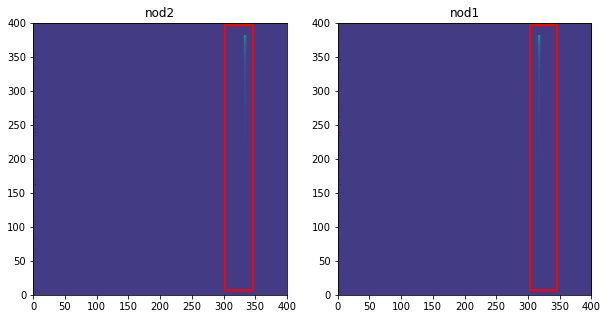

In [55]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=[10,5])

bbox0 = Rectangle((awcs_out[0].meta.wcs.bounding_box[0][0],awcs_out[0].meta.wcs.bounding_box[1][0]), bbox_w, bbox_ht, angle=0.0, ec='r', lw=2, fc='None')
bbox1 = Rectangle((awcs_out[1].meta.wcs.bounding_box[0][0],awcs_out[1].meta.wcs.bounding_box[1][0]), bbox_w, bbox_ht, angle=0.0, ec='r', lw=2, fc='None')

ax[0].imshow(awcs_out[0].data, origin='lower', interpolation='None', aspect='auto')
ax[0].add_patch(bbox0)
ax[0].set_xlim([0,400])
ax[0].set_ylim([0,400])
ax[0].set_title(nods[0])

ax[1].imshow(awcs_out[1].data, origin='lower', interpolation='None', aspect='auto')
ax[1].add_patch(bbox1)
ax[1].set_xlim([0,400])
ax[1].set_ylim([0,400])
ax[1].set_title(nods[1])

np.shape(awcs_out[0].data)


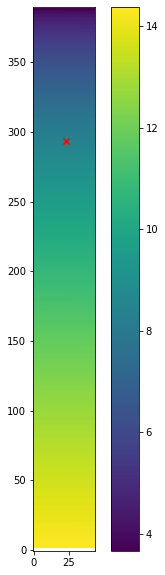

In [50]:
# Plot the wavelength solution based on the wcs information in the model
siaf = Siaf('MIRI')
ap = siaf['MIRIM_SLIT']
refpx_tel = ap.reference_point(to_frame='tel')
refpx_abs = mt.v2v3toxy(refpx_tel[0], refpx_tel[1], filter='F770W')
refpx = (refpx_abs[0] - awcs_out[0].meta.wcs.bounding_box[0][0], refpx_abs[1] - awcs_out[0].meta.wcs.bounding_box[1][0])
#print(refpx)

x,y = grid_from_bounding_box(awcs_out[0].meta.wcs.bounding_box)
ra, dec, lam = awcs_out[0].meta.wcs(x, y)

fig = plt.figure(figsize=[6,10])
imlam=plt.imshow(lam, origin='lower', interpolation='None')
cbar = fig.colorbar(imlam)
plt.scatter(refpx[0], refpx[1], marker='x', color='r')



Load the set of test coordinates from ``miricoord``. Then calculate the wavelength of these coordinates from the assign_wcs output models, and verify that they are close. If all the ``assert`` tests pass, this test is successful and complete.

In [90]:
xt,yt,v2t,v3t,lamt,stype=tv.testdata()

lamtest1 = np.zeros(3)
lamtest2 = np.zeros(3)
v2test1 = np.zeros(3)
v3test1 = np.zeros(3)
lt1 = np.zeros(3)

print('**** TEST SET ****')
print(' x       y     lam_truth  lamtest1  lamtest2  v2truth   v3truth  v2test   v3test')
for i in range (3):
    v2test1[i], v3test1[i], lt1[i] = xytov2v3lam(xt[0][i], yt[0][i], 'slit') 
    ra, dec, lamtest1[i] = awcs_out[0].meta.wcs(xt[0][i], yt[0][i])
    ra, dec, lamtest2[i] = awcs_out[1].meta.wcs(xt[0][i], yt[0][i])
    print('{0}  {1}   {2}    {3:.5f}    {4:.5f}  {5:.5f}   {6:.5f}   {7:.5f}   {8:.5f}'.format(xt[0][i], yt[0][i], lamt[0][i], lamtest1[i], lamtest2[i], v2t[0][i], v3t[0][i], v2test1[i], v3test1[i]))
    
    
    assert_allclose(lamt[0][i], lamtest1[i], atol=0.05)
    assert_allclose(lamt[0][i], lamtest2[i], atol=0.05)
    assert_allclose(v2t[0][i], v2test1[i], atol=0.05)
    assert_allclose(v3t[0][i], v3test1[i], atol=0.05)
    

    


**** TEST SET ****
 x       y     lam_truth  lamtest1  lamtest2  v2truth   v3truth  v2test   v3test
325.13  299.7   8.41039    8.41039    8.41039  -415.06900   -400.57590   -415.06905   -400.57592
325.13  29.7   14.05363    14.05363    14.05363  -415.19460   -400.56550   -415.19455   -400.56549
345.13  379.7   5.1474    5.14743    5.14743  -417.23700   -400.39580   -417.23700   -400.39585


<a id="about_ID"></a>
## About this Notebook
**Author:** Sarah Kendrew, ESA MIRI Instrument & Calibration Scientist, MIRI branch
<br>**Updated On:** 07/27/2020

[Top of Page](#title_ID)
<img style="float: right;" src="./stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="stsci_pri_combo_mark_horizonal_white_bkgd" width="200px"/> 